In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math
import cv2
from scipy.stats import gamma

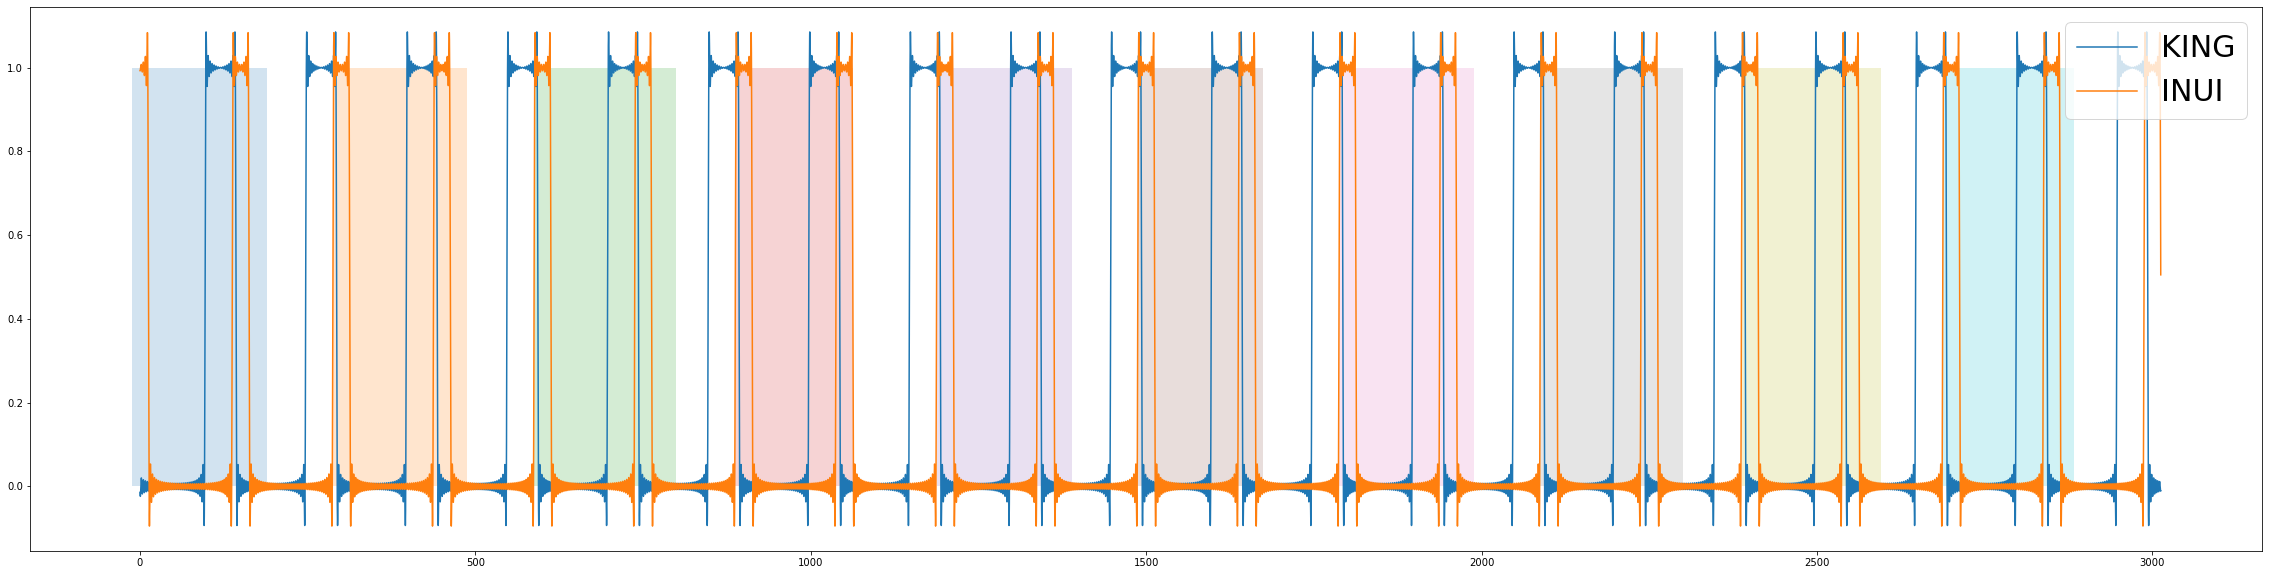

In [13]:
def single_basis(n, t, offset, t_p, t_, A=1):
    return 2*A/n/math.pi*np.sin(n*math.pi*t_p/t_)*np.cos(2*math.pi*n/t_*(t-offset))

def multi_basis(n, t, offset, t_p, t_, A=1):
    a0 = A*t_p/t_
    x_t = np.zeros(len(t))
    for i in range(n):
        x_t += single_basis(i+1, t, offset, t_p, t_, A=1)
    return x_t+a0

t_king = 150 #* Total period
t_p_king = 46 #* Pulse width
t_p_inui = 25 #* Pulse width
A = 1 #* Amplitude
cutoff = 50 #* Number of F series
x_offset_king = 120 #* Offset
t = np.linspace(0, 3012.5, 10000*10) #* Time
# a0 = A*t_p/t_

x_t_50_king = multi_basis(cutoff, t, x_offset_king, t_p_king, t_king, A)
x_t_50_inui = multi_basis(cutoff, t, 0, t_p_inui, t_king, A)
# plt.plot(t, x_t_5)
fig, ax = plt.subplots(figsize=(40,10))

plt.plot(t, x_t_50_king, label='KING')
plt.plot(t, x_t_50_inui, label='INUI')

#* Fill between
n_cycle = 10
x_start = np.arange(n_cycle)*300-12.5
time_consume = np.array([mu_sigma() for i in range(n_cycle)])
x_end = x_start+time_consume
for x_s, x_e in zip(x_start, x_end):
    plt.fill_between([x_s, x_e], [0, 0], [1, 1], alpha=0.2)

plt.legend(fontsize=30, loc='upper right')
plt.show()

$$x_T(t) = \sum_{n=1}\frac{2A}{n\pi}sin(n\pi\frac{t_p}{T})cos(\frac{2\pi n}{T}(t)) + A\frac{T_p}{T}\ \ (T, T_P) \in INUI\ signal \tag{1}$$

$$t = (\epsilon-1/2) T_{I,P} + (\mu+\zeta \sigma) - \eta T_K \tag{2}, \epsilon \in [0,1)$$

$\epsilon$ is the variable for the INUI signal's pulse width, in the **even** condition of wave function, the $t$ should be cut by $1/2t_p$.

$\zeta$ defines the confidence interval of the time consumed during my ride from INUI to KING.

$\eta$ is the variable for the deduction.

$$P(|x(t)| < 0.5) \approx 1 \tag{3}$$
<!-- $$a_0 = A\frac{T_p}{T}\ when\ n = 0 \tag{3}$$ -->

In [ ]:
time_cost

In [2]:
time_cost_n = np.array([
    43.72, 39.19, 40.82, 36.23, 34.09, 27, 25.16, 23.90, 19.73
]) + 3*60

time_cost_d = np.array([
    15.78, 31.12, 21.26, 30.28, 34.89, 11.34, -12.43, -4.11, 11.95, 18.04, 21.72, 25.39, 9.94
]) + 3*60

mu_n = np.mean(time_cost_n)
sigma_n = np.std(time_cost_n, ddof=0)
min_sigma_n, max_sigma_n = np.min((time_cost_n-mu_n)), np.max((time_cost_n-mu_n))
print(f"mu in night: {mu_n}, sigma in night: {sigma_n}")

mu_d = np.mean(time_cost_d)
sigma_d = np.std(time_cost_d, ddof=0)
min_sigma_d, max_sigma_d = np.min((time_cost_d-mu_d)), np.max((time_cost_d-mu_d))
print(f"mu in day: {mu_d}, sigma in day: {sigma_d}")

mu in night: 212.20444444444445, sigma in night: 8.004722371632484
mu in day: 196.55153846153846, sigma in day: 13.084627413732996


In [3]:
time_cost_n_debias = time_cost_n - (mu_n-mu_d)
time_cost_debias = np.concatenate([time_cost_n_debias, time_cost_d])
time_cost = np.concatenate([time_cost_n, time_cost_d])
mu, sigma, min_sigma, max_sigma = mu_d, sigma_d, min_sigma_d, max_sigma_d

(array([2., 4., 9., 7.]),
 array([167.57, 179.4 , 191.23, 203.06, 214.89]),
 <BarContainer object of 4 artists>)

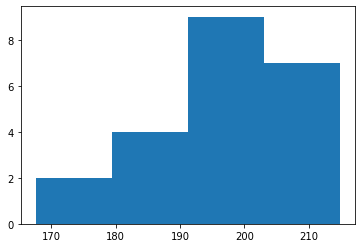

In [12]:
plt.hist(time_cost_debias, bins=4)

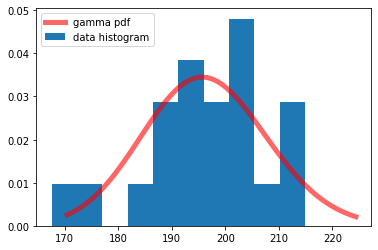

In [28]:
shape, loc, scale = gamma.fit(time_cost_debias)
x = np.linspace(gamma.ppf(0.01, shape, loc, scale), gamma.ppf(0.99, shape, loc, scale), 100)
plt.plot(x, gamma.pdf(x, shape, loc, scale), 'r-', lw=5, alpha=0.6, label='gamma pdf')
plt.hist(time_cost_debias, density=True, label='data histogram')
plt.legend()
plt.show()

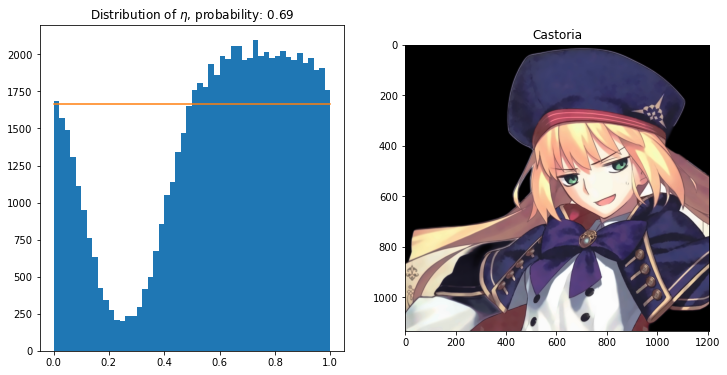

In [4]:
def single_basis(n, t, offset, t_p, t_, A=1):
    return 2*A/n/math.pi*np.sin(n*math.pi*t_p/t_)*np.cos(2*math.pi*n/t_*(t-offset))

def multi_basis(n, t, offset, t_p, t_, A=1):
    a0 = A*t_p/t_
    try:
        x_t = np.zeros(len(t))
    except:
        x_t = 0

    for i in range(n):
        x_t += single_basis(i+1, t, offset, t_p, t_, A=1)
    return x_t+a0

def epsilon(p):
    '''
    probability *p*: start from beginning of green light;
    else: start from random point during green light.
    '''
    epsilon_ = np.random.rand()
    if epsilon_ < p:
        return 0
    else:
        return np.random.rand()

def mu_sigma():
    while 1:
        sigma_samp = np.random.randn()*sigma
        if sigma_samp < max_sigma and sigma_samp > min_sigma:
            break

    return mu + sigma_samp

t_p_inui = 26 #* Pulse width
t_p_king, t_king = 46, 150
n_sample = 100000
count_red = 0 #* Number of cases for meeting with the real condition.
eta_list, time_cost_list = [], []

#* For fourier series
cutoff = 50
threshold = 0.5

for i in range(n_sample):
    epsilon_ = epsilon(0.5)
    time_cost = mu_sigma()
    eta = np.random.rand() #* Treated as offset term on 1D dimension.
    t_king_reach = (epsilon_-1/2)*t_p_inui + time_cost
    offset_ = eta*t_king

    signal_ = multi_basis(cutoff, t_king_reach, offset_, t_p_king, t_king, A=1)
    signal_ = signal_ <= threshold
    if signal_:
        count_red += 1
        eta_list.append(eta)
    
    time_cost_list.append(time_cost)

bins = 50
eta_list = np.array(eta_list)
# print(f"Probability: {count_red/n_sample}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
(n_info, bins_info, patches_info) = ax1.hist(eta_list, bins=bins)
ax1.plot(np.linspace(0, 1, 100), np.ones(100)*n_sample/bins*(1-1/(300/bins))) #* Dist of zeta

castoria = cv2.imread('./alpha_045.png')
castoria = cv2.cvtColor(castoria, cv2.COLOR_BGR2RGB)
# ax2.hist(time_cost_list) #* Dist of time consumed.
ax2.imshow(castoria)

ax1.set_title("Distribution of $\eta$, probability: {:.2f}".format(count_red/n_sample))
ax2.set_title("Castoria")

plt.show()

In [10]:
count_fact_threshold = n_sample/bins*(1-1/(300/bins))
ind_chosen = np.where(n_info < count_fact_threshold)[0]
eta_count = bins_info[ind_chosen]
eta_count

array([4.48612743e-05, 2.00439085e-02, 4.00429558e-02, 6.00420030e-02,
       8.00410503e-02, 1.00040098e-01, 1.20039145e-01, 1.40038192e-01,
       1.60037239e-01, 1.80036287e-01, 2.00035334e-01, 2.20034381e-01,
       2.40033428e-01, 2.60032476e-01, 2.80031523e-01, 3.00030570e-01,
       3.20029617e-01, 3.40028665e-01, 3.60027712e-01, 3.80026759e-01,
       4.00025806e-01, 4.20024854e-01, 4.40023901e-01, 4.60022948e-01])

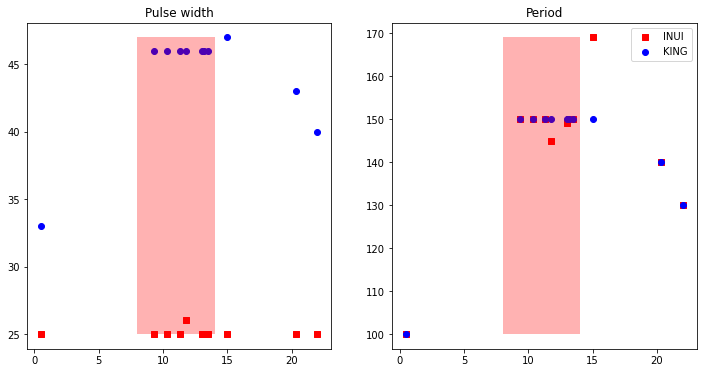

In [46]:
t_ = [11.75, 15, 13, 13.5, 9.333, 13.167, 11.333, 10.333, 0.5, 22, 20.333]

tp_inui = [26,25,25,25,25,25,25,25,25,25,25]
t_inui = np.array([25,49,29,30,30,30,30,30,-20,10,20])+120

tp_king = [46,47,46,46,46,46,46,46,33,40,43]
t_king = np.array([30,30,30,30,30,30,30,30,-20,10,20])+120

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(t_, tp_inui, marker='s', c='r',label='INUI')
ax1.scatter(t_, tp_king, marker='o', c='b',label='KING')
ax2.scatter(t_, t_inui, marker='s', c='r',label='INUI')
ax2.scatter(t_, t_king, marker='o', c='b',label='KING')

x = [8, 14]
y1 = [min(min(tp_inui), min(tp_king)), max(max(tp_inui), max(tp_king))]
y2 = [min(min(t_inui), min(t_king)), max(max(t_inui), max(t_king))]
ax1.fill_between(x, y1[0], y1[1], facecolor='red', alpha=0.3)
ax2.fill_between(x, y2[0], y2[1], facecolor='red', alpha=0.3)

ax1.set_title('Pulse width (s)')
ax2.set_title('Period (s)')

plt.legend()
plt.show()

That's to say, if $\eta$ is randomly distributed, then around 40% conditions is counterfactual.

Next part: deduce the **distribution** of phase difference.

last for 4h -> 14400s, 

State: $t_{king} = t - \eta T_{king},\ t_{inui} = t$

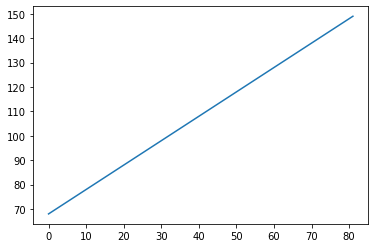

In [15]:
def find_closest(x1, x2, t):
    eta_list, closest_list = [], []
    for i in x1:
        idx = np.searchsorted(x2, i)
        if idx > 0 and idx < len(x2):
            closest = x2[idx] if abs(x2[idx] - i) < abs(x2[idx-1] - i) else x2[idx-1]
        elif idx == 0:
            closest = x2[idx]
        else:
            closest = x2[idx-1]

        diff = i - closest
        if diff > 0:
            eta = 1 - diff/t
        elif diff <= 0:
            eta = -diff/t
        
        closest_list.append(i-closest)
        eta_list.append(eta)
    return eta_list, closest_list

t_inui, t_king, delta_phi_list = 150, 150, []
period_inui, period_king = 14400//t_inui, 14400//t_king
x_inui = np.linspace(0,period_inui*t_inui,period_inui+1)
for delta_phi in range(150):
    x_king = np.linspace(0,period_king*t_king,period_king+1)+delta_phi
    eta_list, closest_list = find_closest(x_inui, x_king, t_king)
    if np.mean(eta_list) >= 0.45:
        delta_phi_list.append(delta_phi)
# plt.hist(eta_list, bins=20)
plt.plot(delta_phi_list)